In [69]:
import yfinance as yf
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from datetime import datetime, timedelta
import statsmodels.api as sm
import pandas_ta as ta

from performance_indicator import *
from trading_computation import *
from plotting_computation import *

In [70]:
LEVERAGE = 10
MAX_LEVERAGE = 10
INITIAL_CAP = 200000
TRAINSIZE = 0.7
INCREASE_RF = True # Explore the situation when effr increase 150%

## 1. Time Series Prep

- The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. It is often used when examining historical returns or doing a detailed analysis of past performance.

In [71]:
end_date = datetime(2019, 12, 31)
start_date = datetime(2014, 1, 1)

# Download data as dataframe
ETF = yf.download('SPTL', start=start_date, end=end_date).reset_index()
EFFR = web.DataReader('EFFR', 'fred', start_date, end_date).dropna().reset_index().rename({'DATE':'Date'}, axis = 1)

[*********************100%***********************]  1 of 1 completed


In [72]:
# The EFFR data will be Nan at weekends or some other federal holidays
# The weekends are not tradings days and hence they are dropped. Otherwise, use forward fill method
# Assuing the EFFR data to the same as the previous day
df = pd.merge(left = ETF, right = EFFR, on = 'Date', how = 'left').ffill(axis = 0)
df = df[['Date', 'Close', 'EFFR']]
df['EFFR'] = pd.to_numeric(df['EFFR'], errors='coerce')
# Adjust the annual risk-free rate to make it a daily rate

if INCREASE_RF:
    df['Daily_EFFR'] = df['EFFR']/(252*100) * 1.5
else:
    df['Daily_EFFR'] = df['EFFR']/(252*100)
# Calculate the daily execess return per unit SPTL
df['Daily_return'] = df['Close'].pct_change(1, fill_method='ffill')
df['Daily_excess_return'] = df['Close'].pct_change(1, fill_method='ffill') - df['Daily_EFFR']

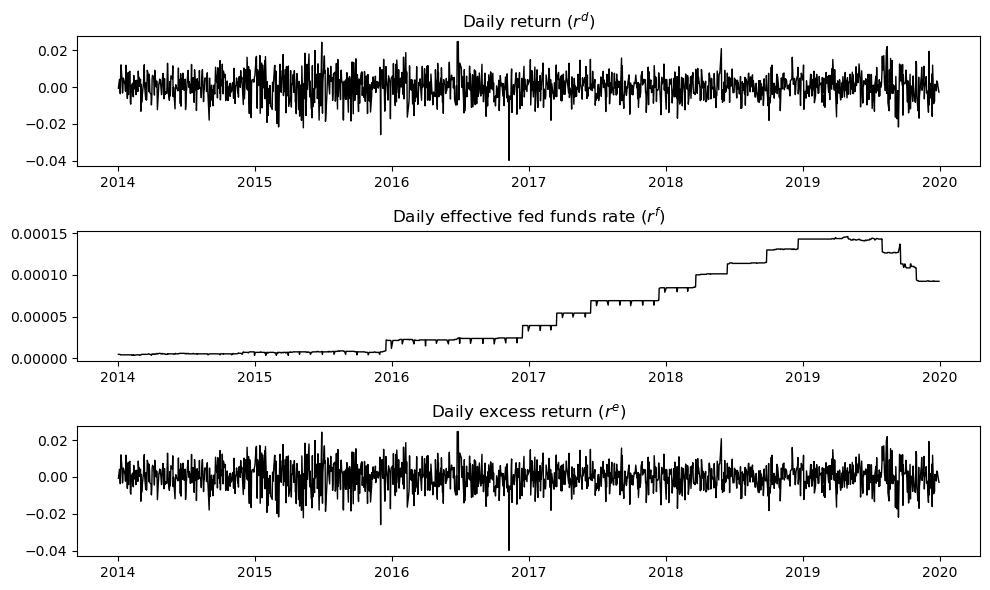

In [73]:
fig, ax = plt.subplots(3, 1, figsize = (10, 6))

ax[0].plot(df['Date'], df['Daily_return'], color = 'black', lw = 1)
ax[0].set_title(r'Daily return ($r^d$)')
ax[1].plot(df['Date'], df['Daily_EFFR'], color = 'black', lw = 1)
ax[1].set_title(r'Daily effective fed funds rate ($r^f$)')
ax[2].plot(df['Date'], df['Daily_excess_return'], color = 'black', lw = 1)
ax[2].set_title(r'Daily excess return ($r^e$)')
plt.tight_layout()

## 2. Trading Strategies

### Strategy: Moving Average and RSI

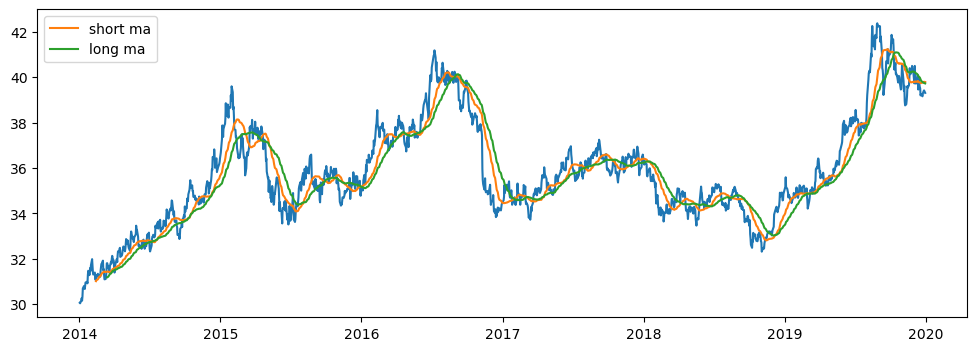

In [74]:
df['RSI'] = ta.rsi(df.Close, length=14)
df['short_MA'] = df['Close'].rolling(30).mean()
df['long_MA'] = df['Close'].rolling(50).mean()
plt.figure(figsize = (12, 4))
plt.plot(df['Date'], df['Close'])
plt.plot(df['Date'], df['short_MA'], label = 'short ma')
plt.plot(df['Date'], df['long_MA'], label = 'long ma')
plt.legend()


In [75]:
train_size = int(len(df) * TRAINSIZE)
train_set = df[:train_size]
test_set = df[train_size:]

In [76]:
# Trading signals
regime = [0]

short_ma = np.array(df['short_MA'])
long_ma = np.array(df['long_MA'])

rsi = np.array(df['RSI'])

for i in range(1, len(df)):
    if short_ma[i] > long_ma[i] and short_ma[i-1] < long_ma[i-1] and rsi[i] <=50:
        regime.append(1)
    elif short_ma[i] < long_ma[i] and short_ma[i-1] > long_ma[i-1] and rsi[i] >=50:
        regime.append(-1)
    else:
        regime.append(0)

regime_train = regime[:train_size]
regime_test = regime[train_size:]

/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:84: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:163: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


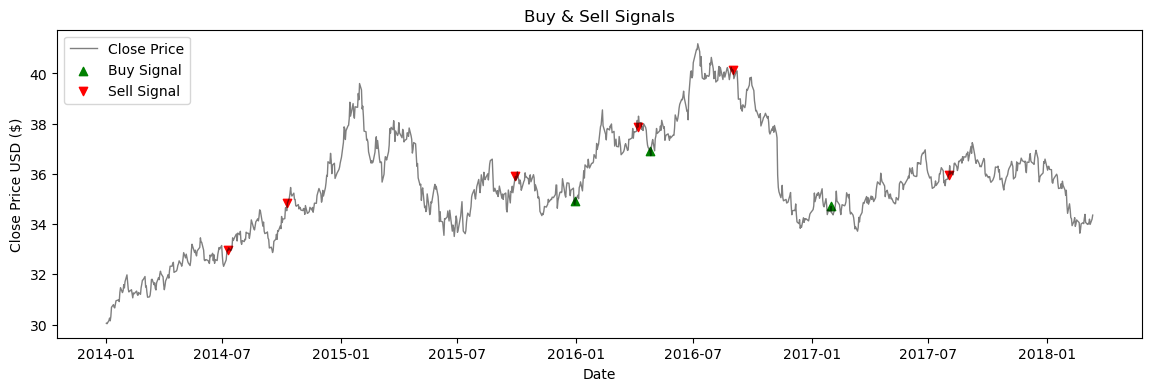

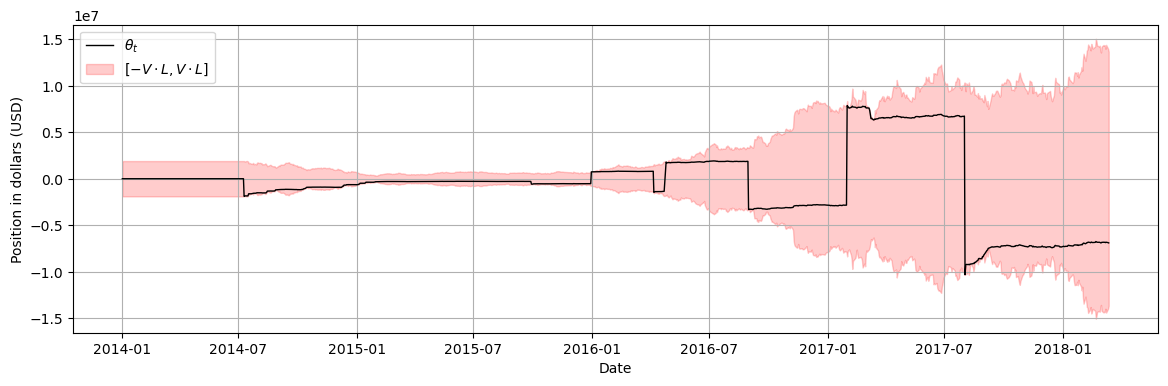

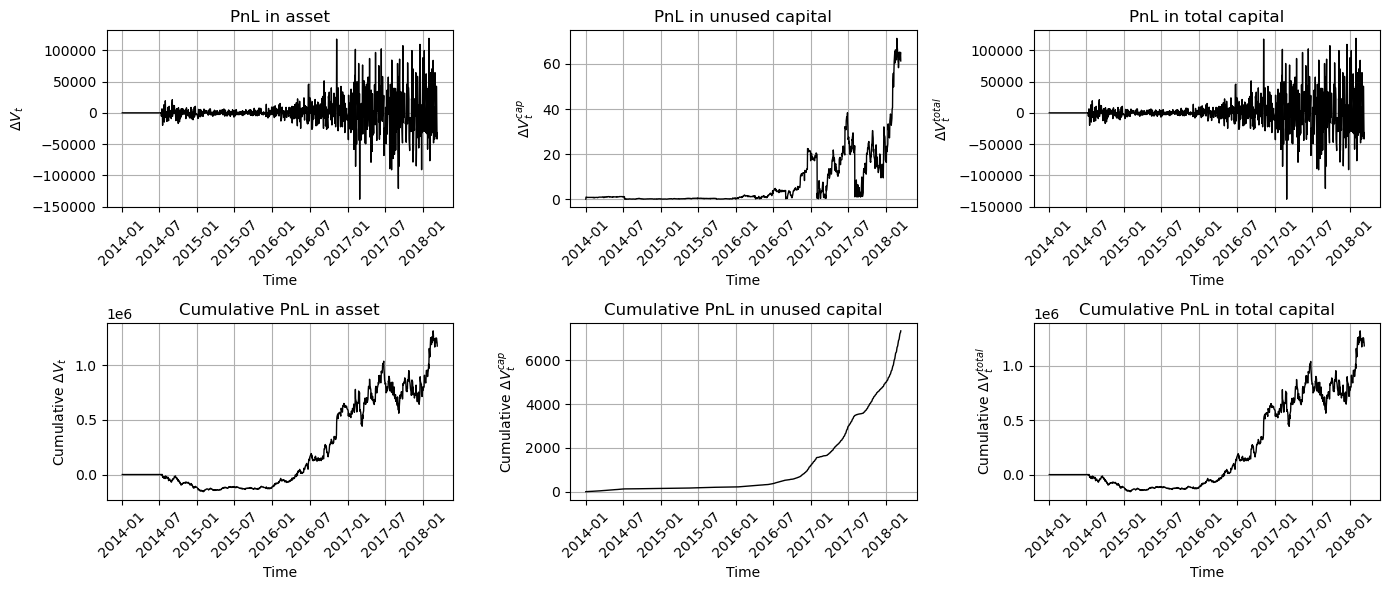

In [77]:
# Training set performance
# train_set = df.copy()
result_train = compute_position_value(df = train_set, 
                           signal = regime_train, 
                           initial_capital = INITIAL_CAP, 
                           max_leverage = LEVERAGE, 
                           reduced_leverage_shorting = False,
                           hold_at_signal_0 = True)

plot_strategy(df = train_set, 
              result_dict = result_train, 
              signal = regime_train, 
              leverage = MAX_LEVERAGE)


/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:189: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


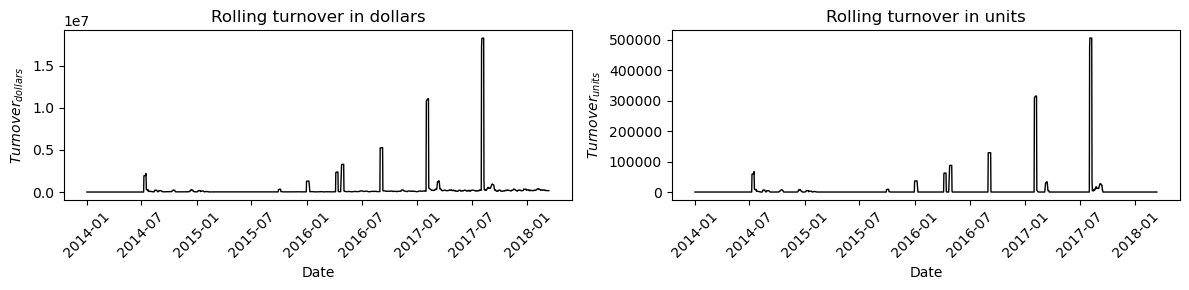

In [78]:
turnover_dollar = calculate_rolling_turnover(theta = result_train['theta'], 
                           price = train_set['Close'], 
                           mode = 'dollar')

turnover_unit = calculate_rolling_turnover(theta = result_train['theta'], 
                           price = train_set['Close'], 
                           mode = 'unit')

    
fig, ax = plot_turnover(train_set, turnover_dollar, turnover_unit, mode = 'Rolling')

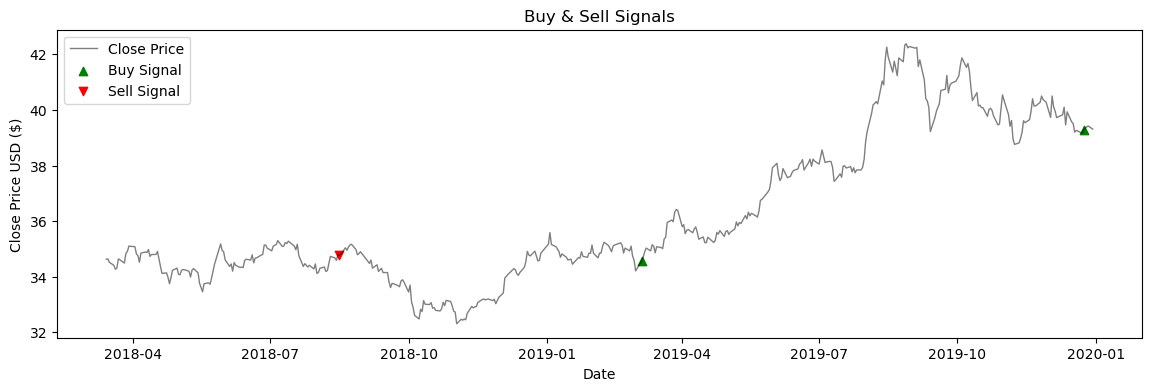

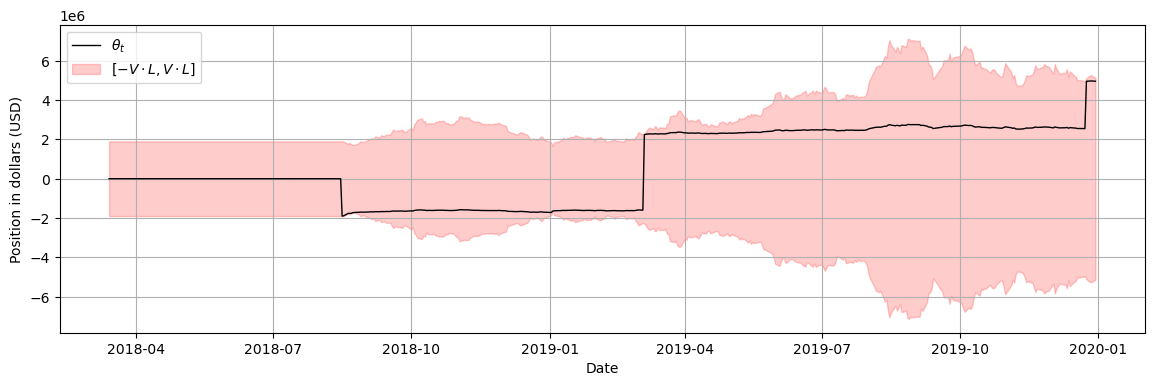

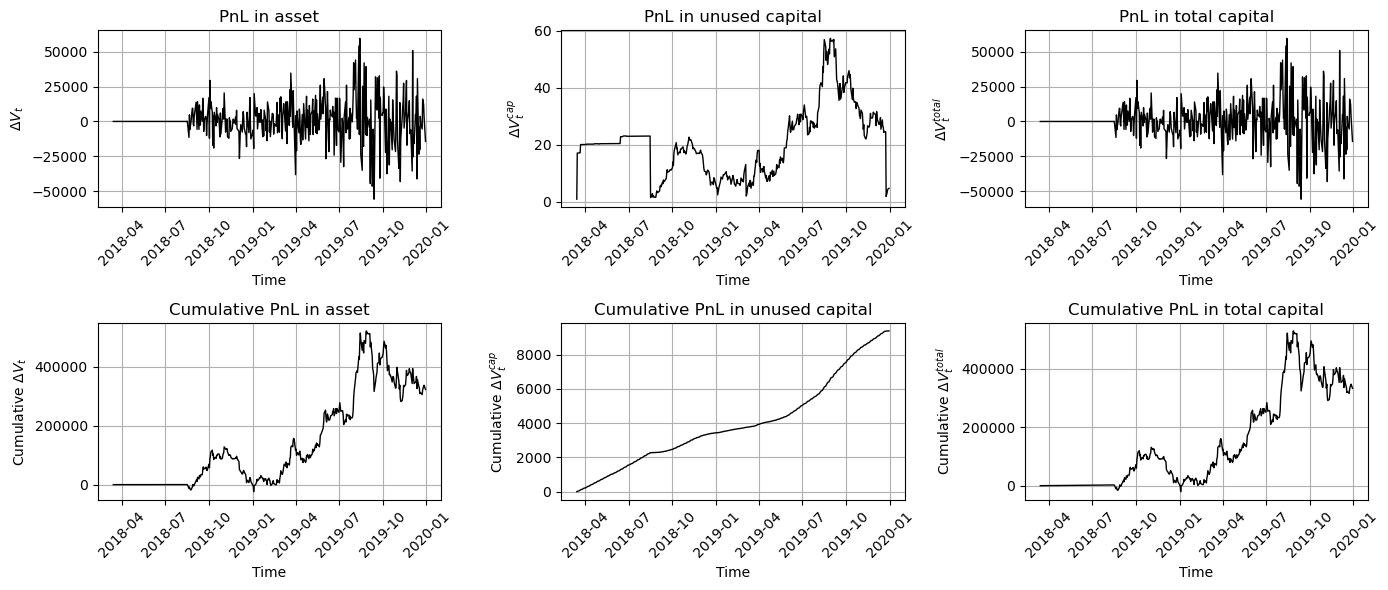

In [79]:
# Testing set performance
result_test = compute_position_value(df = test_set, 
                           signal = regime_test, 
                           initial_capital = INITIAL_CAP, 
                           max_leverage = LEVERAGE, 
                           reduced_leverage_shorting = False,
                           hold_at_signal_0 = True)

plot_strategy(df = test_set, 
              result_dict = result_test, 
              signal = regime_test, 
              leverage = MAX_LEVERAGE)

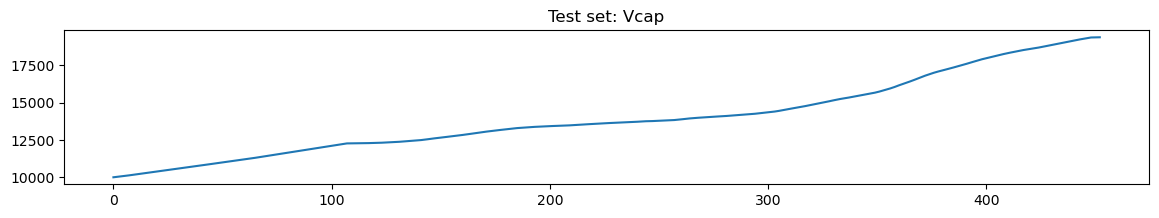

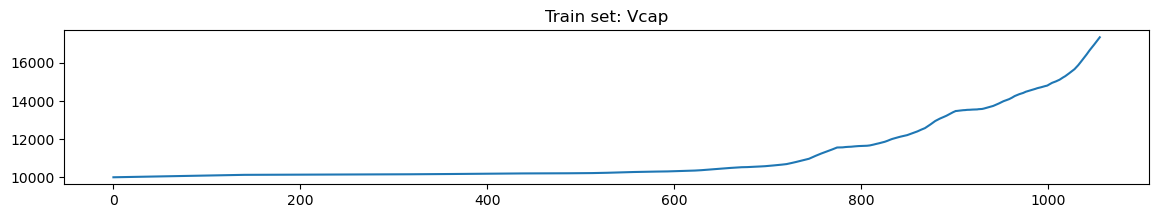

In [80]:
# Check the Vcap
plt.figure(figsize = (14, 2))
plt.title('Test set: Vcap')
plt.plot(result_test['Vcap'])
plt.show()
plt.figure(figsize = (14, 2))
plt.title('Train set: Vcap')
plt.plot(result_train['Vcap'])
plt.show()

/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/trading_computation.py:112: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  turnover = [np.sum(np.abs(np.diff(theta[i:i+window_size] / price[i:i+window_size]))) for i in range(len(theta) - window_size + 1)]


Text(0.5, 1.0, 'MA & RSI rolling turnover in units')

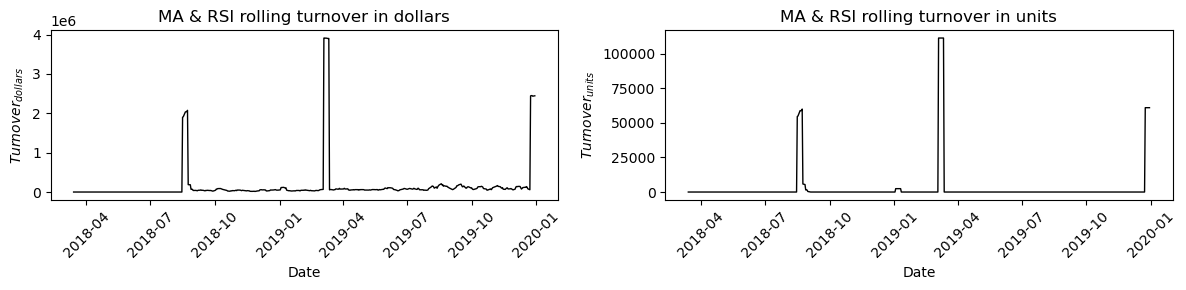

In [81]:
turnover_dollar = calculate_rolling_turnover(theta = result_test['theta'], 
                           price = test_set['Close'], 
                           mode = 'dollar')

turnover_unit = calculate_rolling_turnover(theta = result_test['theta'], 
                           price = test_set['Close'], 
                           mode = 'unit')

    
fig, ax = plot_turnover(test_set, turnover_dollar, turnover_unit, mode = 'Rolling')
ax[0].set_title('MA & RSI rolling turnover in dollars')
ax[1].set_title('MA & RSI rolling turnover in units')

## Train-test comparison

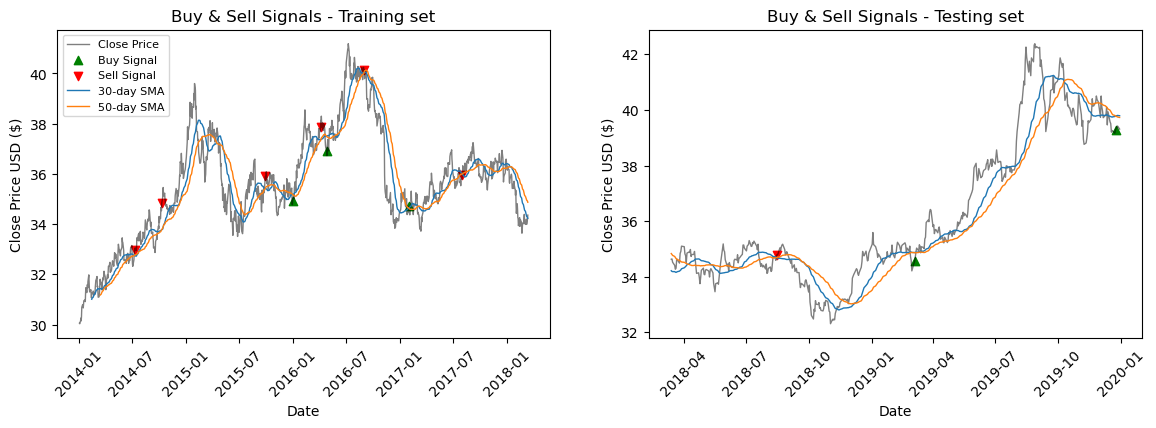

In [82]:
fig, ax = plot_signals_compare(train_data = train_set, 
                     train_signal = regime_train, 
                     test_data = test_set, 
                     test_signal = regime_test)
ax[0].plot(train_set['Date'], train_set['short_MA'], label='30-day SMA', lw = 1,  alpha=1)
ax[0].plot(train_set['Date'], train_set['long_MA'], label='50-day SMA', lw = 1, alpha=1)
ax[0].legend(loc = 'upper left', fontsize = 8)
ax[1].plot(test_set['Date'], test_set['short_MA'], label='30-day SMA', lw = 1,  alpha=1)
ax[1].plot(test_set['Date'], test_set['long_MA'], label='50-day SMA', lw = 1, alpha=1)

/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:110: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


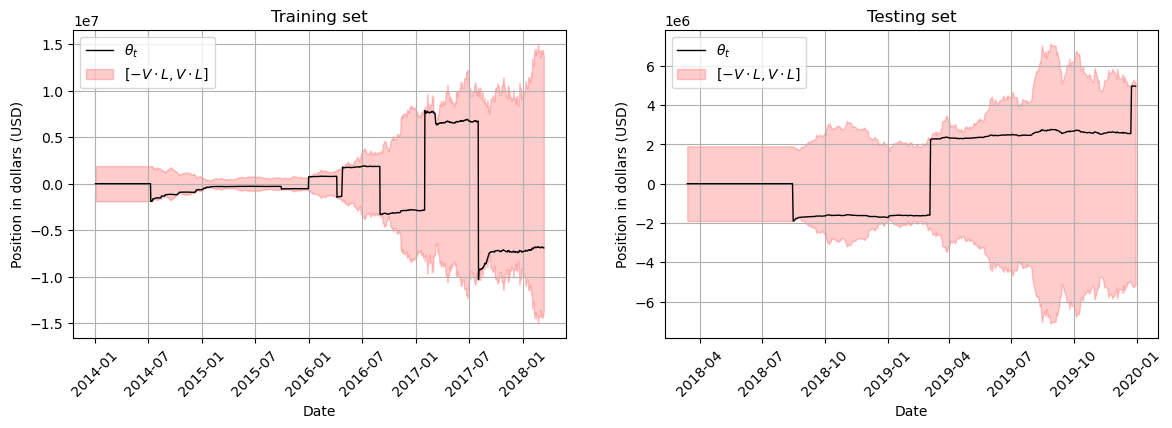

In [83]:
fig, ax = plot_position_compare(train_set_date = train_set['Date'], 
                      train_theta = result_train['theta'], 
                      train_V = result_train['V'], 
                      test_set_date = test_set['Date'], 
                      test_theta = result_test['theta'], 
                      test_V = result_test['V'], 
                      leverage = MAX_LEVERAGE)

In [84]:
df_train_res = pd.DataFrame(result_train)
df_train_res['Date'] = np.array(train_set['Date'])
df_train_res['Close'] = np.array(train_set['Close'])
df_train_res['Signal'] = regime_train


df_test_res = pd.DataFrame(result_test)
df_test_res['Date'] = np.array(test_set['Date'])
df_test_res['Close'] = np.array(test_set['Close'])
df_test_res['Signal'] = regime_test

if INCREASE_RF:
    df_train_res.to_csv('models_data/MA_RSI_TRAIN_RF.csv')
    df_test_res.to_csv('models_data/MA_RSI_TEST_RF.csv')
else:
    df_train_res.to_csv('models_data/MA_RSI_TRAIN.csv')
    df_test_res.to_csv('models_data/MA_RSI_TEST.csv')

In [85]:
df_test_res

,Vtot,Vcap,V,dVtot,dVcap,dV,theta,M,Date,Close,Signal
0,200000.845238,10000.000000,190000.000000,0.000000,0.845238,0.000000,0.000000e+00,0.000000,2018-03-14,34.630001,0
1,200017.869120,10017.023881,190000.000000,17.023881,17.023881,0.000000,0.000000e+00,0.000000,2018-03-15,34.639999,0
2,200034.894450,10034.049212,190000.000000,17.025331,17.025331,-0.000000,0.000000e+00,0.000000,2018-03-16,34.520000,0
3,200051.921230,10051.075992,190000.000000,17.026780,17.026780,-0.000000,0.000000e+00,0.000000,2018-03-19,34.410000,0
4,200069.068537,10068.223299,190000.000000,17.147308,17.147308,-0.000000,0.000000e+00,0.000000,2018-03-20,34.270000,0
...,...,...,...,...,...,...,...,...,...,...,...
448,515032.168086,19366.657268,495664.665580,-5408.314467,24.495902,-5432.810369,2.549365e+06,254936.509333,2019-12-23,39.160000,0
449,531031.429833,19368.444151,511662.140444,15999.261747,1.786883,15997.474864,4.956647e+06,495664.665580,2019-12-24,39.290001,1
450,543223.560401,19371.590764,523851.124399,12192.130569,3.146613,12188.983955,4.969262e+06,496926.200552,2019-12-26,39.389999,0
451,546556.365113,19375.827330,527179.692545,3332.804711,4.236566,3328.568145,4.973047e+06,497304.651419,2019-12-27,39.419998,0
